## **pytorch DNN strategy**

In [6]:
'''
导入DNN需要的库
'''
import torch
from torch.autograd import Variable  # 将多维矩阵放入Variable，可以反向传播
import torch.nn as nn  #参数扩展，计算权重
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score  #评价测试结果，所有分类正确的百分比
from torchvision import datasets
from torchvision import transforms
from tensorflow import keras
import sympy
from sympy import Matrix
import tushare as ts

%config INlineBackend.figure_format='svg' #  为了让数字更清晰的显示在notebook中

In [7]:
torch.cuda.is_available()

False

In [8]:
'''
获取数据
'''
data = ts.get_k_data('hs300',start = '2014-07-01',end = '2021-01-20')
data.set_index('date',inplace=True)
data

本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2


,open,close,high,low,volume,code
date,,,,,,
2014-07-01,2169.20,2164.56,2171.15,2157.13,53323100.0,hs300
2014-07-02,2164.00,2170.87,2171.51,2155.61,59685501.0,hs300
2014-07-03,2169.00,2180.19,2184.96,2164.84,63690690.0,hs300
2014-07-04,2180.45,2178.70,2183.80,2174.07,52851106.0,hs300
2014-07-07,2178.55,2176.29,2186.20,2171.08,50242334.0,hs300
...,...,...,...,...,...,...
2021-01-14,5556.21,5470.46,5568.02,5458.68,243683380.0,hs300
2021-01-15,5471.39,5458.08,5500.63,5390.27,238637435.0,hs300
2021-01-18,5438.16,5518.52,5541.46,5410.78,207051869.0,hs300


In [9]:
'''
获取因子
收益率标签为1天的
'''
data_cleaned = pd.DataFrame()
data_cleaned['Close0'] = np.log(data['close'])
data_cleaned['H_L'] = data['high']-data['low']
data_cleaned['C_O'] = data['close']-data['open']
data_cleaned['volume'] = np.log10(data['volume'])

data_cleaned['Close1'] = data_cleaned['Close0'].shift(1)
data_cleaned['Close2'] = data_cleaned['Close0'].shift(2)
data_cleaned['Close3'] = data_cleaned['Close0'].shift(3)
data_cleaned['Close4'] = data_cleaned['Close0'].shift(4)
data_cleaned['Close5'] = data_cleaned['Close0'].shift(5)

data_cleaned['H_L1'] = data_cleaned['H_L'].shift(1)
data_cleaned['H_L2'] = data_cleaned['H_L'].shift(2)
data_cleaned['H_L3'] = data_cleaned['H_L'].shift(3)
data_cleaned['H_L4'] = data_cleaned['H_L'].shift(4)
data_cleaned['H_L5'] = data_cleaned['H_L'].shift(5)

data_cleaned['C_O1'] = data_cleaned['C_O'].shift(1)
data_cleaned['C_O2'] = data_cleaned['C_O'].shift(2)
data_cleaned['C_O3'] = data_cleaned['C_O'].shift(3)
data_cleaned['C_O4'] = data_cleaned['C_O'].shift(4)
data_cleaned['C_O5'] = data_cleaned['C_O'].shift(5)

data_cleaned['volume1'] = data_cleaned['volume'].shift(1)
data_cleaned['volume2'] = data_cleaned['volume'].shift(2)
data_cleaned['volume3'] = data_cleaned['volume'].shift(3)
data_cleaned['volume4'] = data_cleaned['volume'].shift(4)
data_cleaned['volume5'] = data_cleaned['volume'].shift(5)

data_cleaned['Close0_shift(-1)'] = data_cleaned['Close0'].shift(-1)
data_cleaned['label'] =0.5 + 0.5*np.sign(data_cleaned['Close0_shift(-1)']-data_cleaned['Close0'])
data_cleaned.head(23)

,Close0,H_L,C_O,volume,Close1,Close2,Close3,Close4,Close5,H_L1,...,C_O3,C_O4,C_O5,volume1,volume2,volume3,volume4,volume5,Close0_shift(-1),label
date,,,,,,,,,,,,,,,,,,,,,
2014-07-01,7.679972,14.02,-4.64,7.726915,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.682883,1.0
2014-07-02,7.682883,15.90,6.87,7.775869,7.679972,NaN,NaN,NaN,NaN,14.02,...,NaN,NaN,NaN,7.726915,NaN,NaN,NaN,NaN,7.687167,1.0
2014-07-03,7.687167,20.12,11.19,7.804076,7.682883,7.679972,NaN,NaN,NaN,15.90,...,NaN,NaN,NaN,7.775869,7.726915,NaN,NaN,NaN,7.686484,0.0
2014-07-04,7.686484,9.73,-1.75,7.723054,7.687167,7.682883,7.679972,NaN,NaN,20.12,...,-4.64,NaN,NaN,7.804076,7.775869,7.726915,NaN,NaN,7.685377,0.0
2014-07-07,7.685377,15.12,-2.26,7.701070,7.686484,7.687167,7.682883,7.679972,NaN,9.73,...,6.87,-4.64,NaN,7.723054,7.804076,7.775869,7.726915,NaN,7.687296,1.0
2014-07-08,7.687296,17.42,5.64,7.705381,7.685377,7.686484,7.687167,7.682883,7.679972,15.12,...,11.19,6.87,-4.64,7.701070,7.723054,7.804076,7.775869,7.726915,7.672623,0.0
2014-07-09,7.672623,30.25,-29.43,7.792546,7.687296,7.685377,7.686484,7.687167,7.682883,17.42,...,-1.75,11.19,6.87,7.705381,7.701070,7.723054,7.804076,7.775869,7.669892,0.0
2014-07-10,7.669892,12.25,-3.75,7.746109,7.672623,7.687296,7.685377,7.686484,7.687167,30.25,...,-2.26,-1.75,11.19,7.792546,7.705381,7.701070,7.723054,7.804076,7.672297,1.0
2014-07-11,7.672297,19.95,11.69,7.787986,7.669892,7.672623,7.687296,7.685377,7.686484,12.25,...,5.64,-2.26,-1.75,7.746109,7.792546,7.705381,7.701070,7.723054,7.683293,1.0


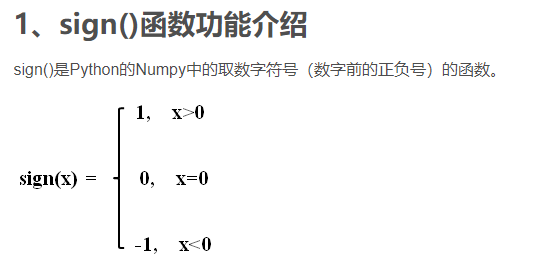

In [10]:
# 去掉多余的数据和空值
data_cleaned.dropna(inplace=True)
data_cleaned.drop(['Close0_shift(-1)'],axis=1,inplace=True)
data_cleaned

,Close0,H_L,C_O,volume,Close1,Close2,Close3,Close4,Close5,H_L1,...,C_O2,C_O3,C_O4,C_O5,volume1,volume2,volume3,volume4,volume5,label
date,,,,,,,,,,,,,,,,,,,,,
2014-07-08,7.687296,17.42,5.64,7.705381,7.685377,7.686484,7.687167,7.682883,7.679972,15.12,...,-1.75,11.19,6.87,-4.64,7.701070,7.723054,7.804076,7.775869,7.726915,0.0
2014-07-09,7.672623,30.25,-29.43,7.792546,7.687296,7.685377,7.686484,7.687167,7.682883,17.42,...,-2.26,-1.75,11.19,6.87,7.705381,7.701070,7.723054,7.804076,7.775869,0.0
2014-07-10,7.669892,12.25,-3.75,7.746109,7.672623,7.687296,7.685377,7.686484,7.687167,30.25,...,5.64,-2.26,-1.75,11.19,7.792546,7.705381,7.701070,7.723054,7.804076,1.0
2014-07-11,7.672297,19.95,11.69,7.787986,7.669892,7.672623,7.687296,7.685377,7.686484,12.25,...,-29.43,5.64,-2.26,-1.75,7.746109,7.792546,7.705381,7.701070,7.723054,1.0
2014-07-14,7.683293,26.62,22.22,7.820588,7.672297,7.669892,7.672623,7.687296,7.685377,19.95,...,-3.75,-29.43,5.64,-2.26,7.787986,7.746109,7.792546,7.705381,7.701070,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-13,8.626580,109.58,-31.29,8.417588,8.629870,8.601748,8.611672,8.614984,8.597421,178.72,...,-63.08,-30.86,85.27,31.16,8.350675,8.365181,8.310321,8.342170,8.287294,0.0
2021-01-14,8.607118,109.34,-85.75,8.386826,8.626580,8.629870,8.601748,8.611672,8.614984,109.58,...,176.85,-63.08,-30.86,85.27,8.417588,8.350675,8.365181,8.310321,8.342170,0.0
2021-01-15,8.604852,110.36,-13.31,8.377739,8.607118,8.626580,8.629870,8.601748,8.611672,109.34,...,-31.29,176.85,-63.08,-30.86,8.386826,8.417588,8.350675,8.365181,8.310321,1.0


In [11]:
# 将数据分成训练集和测试集
traning_set = data_cleaned.iloc[:999,:]
test_set = data_cleaned.iloc[999:,:]

In [12]:
traning_set

,Close0,H_L,C_O,volume,Close1,Close2,Close3,Close4,Close5,H_L1,...,C_O2,C_O3,C_O4,C_O5,volume1,volume2,volume3,volume4,volume5,label
date,,,,,,,,,,,,,,,,,,,,,
2014-07-08,7.687296,17.42,5.64,7.705381,7.685377,7.686484,7.687167,7.682883,7.679972,15.12,...,-1.75,11.19,6.87,-4.64,7.701070,7.723054,7.804076,7.775869,7.726915,0.0
2014-07-09,7.672623,30.25,-29.43,7.792546,7.687296,7.685377,7.686484,7.687167,7.682883,17.42,...,-2.26,-1.75,11.19,6.87,7.705381,7.701070,7.723054,7.804076,7.775869,0.0
2014-07-10,7.669892,12.25,-3.75,7.746109,7.672623,7.687296,7.685377,7.686484,7.687167,30.25,...,5.64,-2.26,-1.75,11.19,7.792546,7.705381,7.701070,7.723054,7.804076,1.0
2014-07-11,7.672297,19.95,11.69,7.787986,7.669892,7.672623,7.687296,7.685377,7.686484,12.25,...,-29.43,5.64,-2.26,-1.75,7.746109,7.792546,7.705381,7.701070,7.723054,1.0
2014-07-14,7.683293,26.62,22.22,7.820588,7.672297,7.669892,7.672623,7.687296,7.685377,19.95,...,-3.75,-29.43,5.64,-2.26,7.787986,7.746109,7.792546,7.705381,7.701070,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-01,8.145373,96.83,-82.64,7.955922,8.165551,8.164818,8.166566,8.170822,8.182489,35.00,...,-5.77,-12.54,-47.07,-11.76,7.832386,7.914433,7.846202,7.955926,7.985689,0.0
2018-08-02,8.122953,112.25,-63.39,8.005647,8.145373,8.165551,8.164818,8.166566,8.170822,96.83,...,7.19,-5.77,-12.54,-47.07,7.955922,7.832386,7.914433,7.846202,7.955926,0.0
2018-08-03,8.106297,66.14,-51.38,7.850014,8.122953,8.145373,8.165551,8.164818,8.166566,112.25,...,-82.64,7.19,-5.77,-12.54,8.005647,7.955922,7.832386,7.914433,7.846202,0.0


In [9]:
# 查看维度
traning_set.shape

(999, 25)

## **Traning DNN Model**

In [13]:
class DeepNeuralNetworkMdoel(nn.Module):
    # constructor of the class
    def __init__(self):
        super(DeepNeuralNetworkMdoel,self).__init__()
        # Fully connected Layer1
        self.FC_layer1 = nn.Linear(24,48)
        
        # Fully connected Layer2
        self.FC_layer2 = nn.Linear(48,36)
        
        # Fully connected Layer3
        self.FC_layer3 = nn.Linear(36,24)
        
        # Fully connected Layer4
        self.FC_layer4 = nn.Linear(24,12)
        
        # Fully connected Layer5
        self.FC_layer5 = nn.Linear(12,2)
        
    # Forward propagation function
    def forward(self,input_data):  # dim of input_data N * 24
        z1_= self.FC_layer1(input_data)
        z1 = torch.sigmoid(z1_)
        
        z2_= self.FC_layer2(z1)
        z2 = torch.sigmoid(z2_)
        
        z3_= self.FC_layer3(z2)
        z3 = torch.sigmoid(z3_)
        
        z4_= self.FC_layer4(z3)
        z4 = torch.sigmoid(z4_)
        
        z5_= self.FC_layer5(z4)   # 最后一层不加激活函数,后面调用entrypyloss函数
        
        return z5_

In [14]:
x = traning_set.iloc[:,0:24]
y = traning_set.iloc[:,24]
x = np.array(x)
y = np.array(y)
x,y

(array([[  7.68729573,  17.42      ,   5.64      , ...,   7.80407595,
           7.77586884,   7.72691539],
        [  7.67262294,  30.25      , -29.43      , ...,   7.72305408,
           7.80407595,   7.77586884],
        [  7.669892  ,  12.25      ,  -3.75      , ...,   7.70106981,
           7.72305408,   7.80407595],
        ...,
        [  8.10629736,  66.14      , -51.38      , ...,   7.83238638,
           7.91443305,   7.84620163],
        [  8.09354476,  86.56      , -39.55      , ...,   7.95592151,
           7.83238638,   7.91443305],
        [  8.12233266, 105.46      ,  83.89      , ...,   8.00564686,
           7.95592151,   7.83238638]]),
 array([0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0.,
        0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1.,
        1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 1

In [15]:
x = Variable(torch.FloatTensor(x))  # x为浮点类型的数据，所以用FloatTensor
y = Variable(torch.LongTensor(y)) # y需要转为int型数据
x.shape,y.shape

(torch.Size([999, 24]), torch.Size([999]))

In [37]:
alpha = 1.0
DNN_Model = DeepNeuralNetworkMdoel()
optimizer = torch.optim.SGD(DNN_Model.parameters(),lr = alpha)
loss_function = nn.CrossEntropyLoss()

# 动态调整学习率
def adjust_learning_rate(optimizer,epoch):
    if epoch <=100:
        lr = alpha
    elif epoch > 100:
        lr = alpha / (1 + 0.002 * (epoch-100))
    elif epoch > 10000:
        lr = alpha / (1 + 0.001 * (epoch-100))
    elif epoch > 50000:
        lr = alpha / (1 + 0.0008 * (epoch-100))
    elif epoch > 100000:
        lr = alpha / (1 + 0.0005 * (epoch-100))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        

1.1千万次迭代     
2.forward传入的是训练集     
3.损失函数算的是输出的预测值与真实值之间的差异     
4.将损失值传入loss_list    
5.每次训练都得到一个w,b,然后每次将w,b改变一个很小的值，不断改变w,b，使得y与y_hat趋近

In [38]:
Iter_times = 10000000
loss_list = []
for i in range(Iter_times):
    outputs = DNN_Model.forward(x)  # 前向传播
    loss = loss_function(outputs,y) # 计算loss
    loss.backward() # 反向传播
    optimizer.step() # 更新参数
    optimizer.zero_grad() # 梯度清零
    
    if (i+1) % 500 == 0:
        print(i+1,'iterations have been completed!')
        print('     --> Now loss = ',loss)
        print('===========================')
    
    adjust_learning_rate(optimizer,i)
    loss_list.append(loss)
    if loss < 0.01:
        print('traning has been totally completed')
        break

500 iterations have been completed!
     --> Now loss =  tensor(0.6882, grad_fn=<NllLossBackward>)
1000 iterations have been completed!
     --> Now loss =  tensor(0.6881, grad_fn=<NllLossBackward>)
1500 iterations have been completed!
     --> Now loss =  tensor(0.6879, grad_fn=<NllLossBackward>)
2000 iterations have been completed!
     --> Now loss =  tensor(0.6876, grad_fn=<NllLossBackward>)
2500 iterations have been completed!
     --> Now loss =  tensor(0.6868, grad_fn=<NllLossBackward>)
3000 iterations have been completed!
     --> Now loss =  tensor(0.6838, grad_fn=<NllLossBackward>)
3500 iterations have been completed!
     --> Now loss =  tensor(0.6614, grad_fn=<NllLossBackward>)
4000 iterations have been completed!
     --> Now loss =  tensor(0.5995, grad_fn=<NllLossBackward>)
4500 iterations have been completed!
     --> Now loss =  tensor(0.5922, grad_fn=<NllLossBackward>)
5000 iterations have been completed!
     --> Now loss =  tensor(0.3805, grad_fn=<NllLossBackward>)
5

In [39]:
'''
（1）如果tensor只有一个元素，然后转换成int或者float类型的时候直接用int()或者float()就可以了；

（2）如果tensor含有多个元素，转换成ndarray时就要用x.detach().numpy()操作了（视情况使用,cpu()）；
'''
loss_list1 = [float(x.detach()) for x in loss_list]
loss_list1

[0.800163984298706,
 0.8309003114700317,
 0.8131172060966492,
 0.8071346282958984,
 0.7703815698623657,
 0.7530996203422546,
 0.729813277721405,
 0.7179836630821228,
 0.7069706916809082,
 0.7009865045547485,
 0.6962601542472839,
 0.6935564279556274,
 0.6915972828865051,
 0.6904343366622925,
 0.6896310448646545,
 0.6891406178474426,
 0.6888116598129272,
 0.6886079907417297,
 0.6884725689888,
 0.6883881092071533,
 0.6883326172828674,
 0.6882973909378052,
 0.6882752776145935,
 0.6882601380348206,
 0.6882511973381042,
 0.688244104385376,
 0.6882399916648865,
 0.6882373094558716,
 0.6882364749908447,
 0.6882348656654358,
 0.6882333755493164,
 0.6882334351539612,
 0.6882322430610657,
 0.6882324814796448,
 0.688231885433197,
 0.6882319450378418,
 0.6882314085960388,
 0.6882311701774597,
 0.6882303357124329,
 0.6882304549217224,
 0.6882301568984985,
 0.6882299780845642,
 0.6882299780845642,
 0.6882292032241821,
 0.6882297396659851,
 0.6882290244102478,
 0.6882290840148926,
 0.6882284283638,
 0

The length of loss_list is: 182395


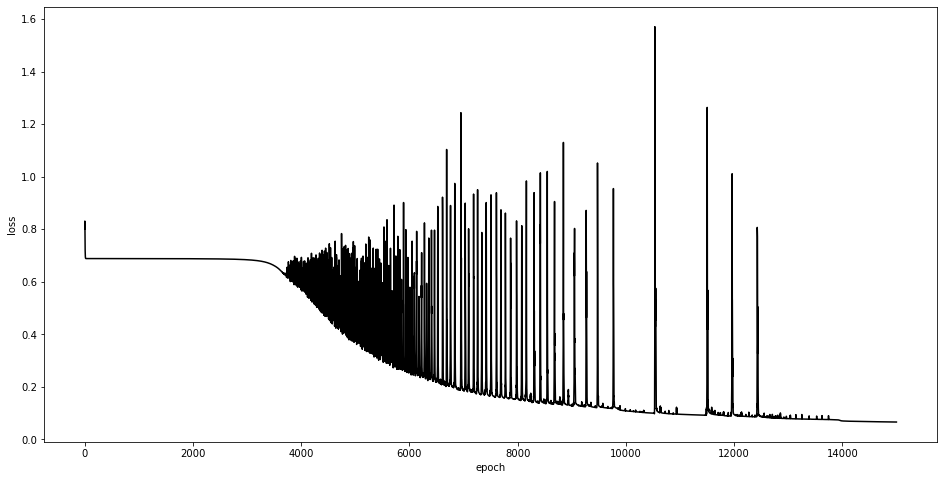

In [40]:
'''
画出损失函数图像
'''
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
length = loss_list.__len__()
print('The length of loss_list is:',length)
plt.plot(np.arange(0,15000,2),loss_list1[:15000],'black')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

Softmax是一个产生激活作用的概率分布密度函数  
为什么dim需要等于1？   
首先dim=1意思是使得在softmax操作之后在dim这个维度相加等于1  

In [45]:
Probability_Calculator = nn.Softmax(dim=1)
pred = []
# x.detach()都是从原有计算中分离出来的一个tensor变量,但是没有更改这个tensor时，并不会影响backward()
# numpy()将tensor转变为array数组
prob = Probability_Calculator(DNN_Model.forward(x)).detach().numpy()   

In [46]:
prob

array([[9.9793446e-01, 2.0654975e-03],
       [9.9741769e-01, 2.5823605e-03],
       [3.5692580e-08, 1.0000000e+00],
       ...,
       [9.9813253e-01, 1.8674860e-03],
       [6.5254078e-08, 9.9999988e-01],
       [9.9962485e-01, 3.7512733e-04]], dtype=float32)

>>> import numpy as np   
>>> y = np.array([[1,2,3],[4,5,6]])      
>>> print(y)    
[[1 2 3]
 [4 5 6]]       
>>> print(y.shape) # 展示行数，列数       
(2, 3)        
>>> print(y.shape[0]) # 展示行数        
2       
>>> print(y.shape[1]) # 展示列数       
3

In [47]:
for i in range(prob.shape[0]):     
    pred.append(np.argmax(prob[i,:]))  #np.argmax()最大值的索引
pred = np.array(pred)
pred

array([0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,

In [48]:
Probability_Calculator = nn.Softmax(dim=1)   # softmax的dim这个参数 意思就是使得在softmax操作之后在dim这个维度相加等于1
pred = []
# x.detach()都是从原有计算中分离出来的一个tensor变量,但是没有更改这个tensor时，并不会影响backward()
# numpy()将tensor转变为array数组
prob = Probability_Calculator(DNN_Model.forward(x)).detach().numpy()
# numpy.argmax(array, axis) 用于返回一个numpy数组中最大值的索引值。当一组中同时出现几个最大值时，返回第一个最大值的索引值。
for i in range(prob.shape[0]):
    pred.append(np.argmax(prob[i,:]))

pred = np.array(pred)
pred.shape
accuracy_score(pred,y)

0.998998998998999

## **Prediction，Backtesting，Computing Gain/loss**

In [49]:
x = test_set.iloc[:,0:24]
y = test_set.iloc[:,24]
x = np.array(x)
y = np.array(y)
x = Variable(torch.FloatTensor(x))
y = Variable(torch.LongTensor(y))

In [50]:
Probability_Calculator = nn.Softmax(dim=1)
pred = []
prob = Probability_Calculator(DNN_Model.forward(x)).detach().numpy()
for i in range(prob.shape[0]):
    if np.max(prob[i,:]) >= 0.95:
        pred.append(np.argmax(prob[i,:]))
    else:
        pred.append(np.nan)
pred = np.array(pred)

In [53]:
pred

array([ 0.,  1.,  0.,  1.,  0.,  1., nan, nan,  0.,  0., nan,  1.,  1.,
        0.,  0., nan,  0., nan,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
       nan,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,
        0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,
        0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,
        1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0., nan,  1.,  0.,
        1.,  1.,  1.,  1.,  1.,  1., nan,  1.,  1.,  0.,  0.,  1.,  1.,
       nan,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,
        0.,  0.,  1., nan,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,
        1.,  0.,  0.,  0., nan,  1., nan,  1.,  0.,  1.,  0.,  1.,  0.,
       nan,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,
        1.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,
        1.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,
        0.,  1.,  0.,  1.,  1., nan,  1.,  0.,  1.,  1.,  0.,  1

In [51]:
pred.shape

(596,)

In [52]:
hs300 = np.exp(test_set['Close0'])
hs300

date
2018-08-08    3314.51
2018-08-09    3397.53
2018-08-10    3405.02
2018-08-13    3390.34
2018-08-14    3372.91
               ...   
2021-01-13    5577.97
2021-01-14    5470.46
2021-01-15    5458.08
2021-01-18    5518.52
2021-01-19    5437.52
Name: Close0, Length: 596, dtype: float64

In [54]:
pred = 2 * pred-1
rtn_temp = 1.0
cum_rtn = []
cum_rtn.append(rtn_temp)
for i in range(pred.shape[0]-1):
    if pred[i] == 1: #  or pred[i] == -1
        rtn_temp = rtn_temp * (1.0 + ((hs300[i+1]-hs300[i]) / hs300[i]) * pred[i])
    else:
        rtn_temp = rtn_temp
    cum_rtn.append(rtn_temp)

In [55]:
cum_rtn = np.array(cum_rtn)
cum_rtn

array([1.        , 1.        , 1.00220454, 1.00220454, 0.99705213,
       0.99705213, 0.99243332, 0.99243332, 0.99243332, 0.99243332,
       0.99243332, 0.99243332, 0.99401761, 1.01830211, 1.01830211,
       1.01830211, 1.01830211, 1.01830211, 1.01830211, 1.01830211,
       1.01830211, 1.01830211, 1.01830211, 1.01830211, 1.01645471,
       1.00945916, 1.00945916, 1.00945916, 0.99788588, 0.99788588,
       0.99788588, 0.99788588, 0.99788588, 0.9889062 , 0.9889062 ,
       0.98495606, 0.99516275, 0.95234499, 0.95234499, 0.95029186,
       0.95029186, 0.96447273, 0.95100364, 0.95100364, 0.95630306,
       0.95630306, 0.95630306, 0.95630306, 0.93090902, 0.93230388,
       0.93230388, 0.92627105, 0.89803322, 0.89803322, 0.89803322,
       0.90464214, 0.90464214, 0.89710586, 0.89169217, 0.88585231,
       0.88585231, 0.88585231, 0.89639604, 0.89639604, 0.88741375,
       0.89777772, 0.90201412, 0.90201412, 0.90201412, 0.90201412,
       0.90201412, 0.88210456, 0.88147598, 0.88035353, 0.88035

In [56]:
time = test_set.index
time

Index(['2018-08-08', '2018-08-09', '2018-08-10', '2018-08-13', '2018-08-14',
       '2018-08-15', '2018-08-16', '2018-08-17', '2018-08-20', '2018-08-21',
       ...
       '2021-01-06', '2021-01-07', '2021-01-08', '2021-01-11', '2021-01-12',
       '2021-01-13', '2021-01-14', '2021-01-15', '2021-01-18', '2021-01-19'],
      dtype='object', name='date', length=596)

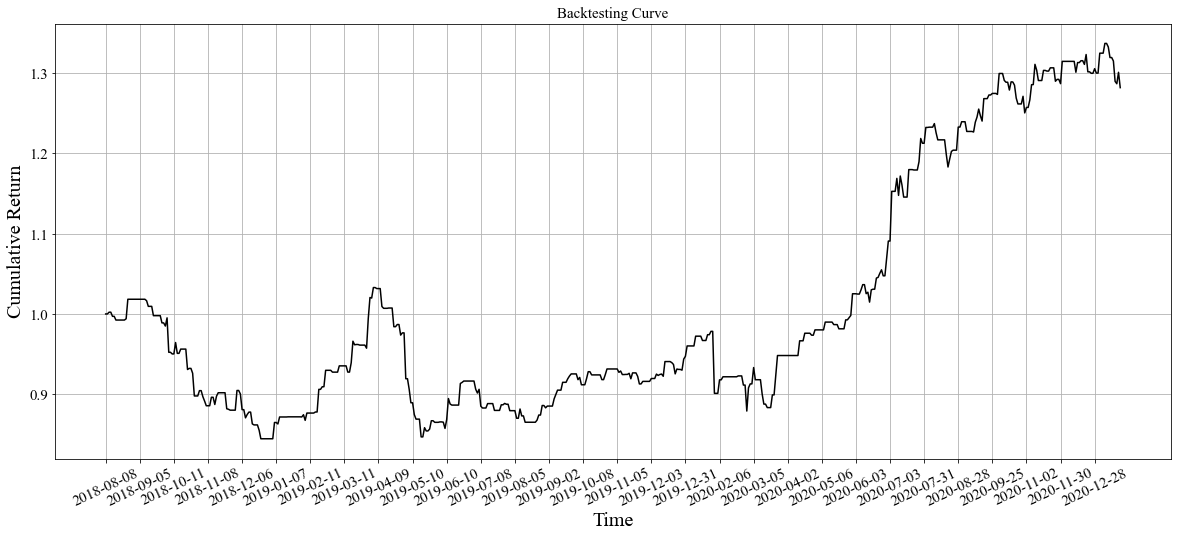

In [57]:
fontTNR = 'Times New Roman'
plt.figure(figsize=(20,8))
plt.plot(time,cum_rtn,color='black')
plt.xticks(test_set.index[::20])   # 这里的20是指隔20个间隔再画
plt.grid()

plt.title('Backtesting Curve',fontsize = 15 , fontproperties = fontTNR)
plt.xlabel('Time',fontsize = 20 ,fontproperties = fontTNR)
plt.ylabel('Cumulative Return',fontsize = 20 ,fontproperties = fontTNR)

plt.xticks(fontsize = 15 , fontproperties = fontTNR,rotation=25)
plt.yticks(fontsize = 15 , fontproperties = fontTNR)
plt.show()

In [22]:
DNN_Model.state_dict()

OrderedDict([('FC_layer1.weight',
              tensor([[-0.0861, -0.5635, -0.5108,  ...,  0.2102, -0.1364, -0.0351],
                      [ 0.3539,  0.0451, -0.6862,  ...,  0.1420,  0.3328,  0.3169],
                      [-0.0257, -0.1801,  0.1551,  ...,  0.1295, -0.0307,  0.3293],
                      ...,
                      [-0.6684, -0.7623, -0.8492,  ..., -0.4728, -0.2793, -0.3192],
                      [-0.0980,  0.4759,  0.2353,  ..., -0.3693, -0.1182, -0.0647],
                      [-0.3859,  0.1895, -0.0720,  ..., -0.2732, -0.2560, -0.2556]])),
             ('FC_layer1.bias',
              tensor([ 0.1029, -0.0978,  0.0527,  0.1733, -0.1503, -0.2079,  0.0588, -0.1384,
                       0.0311, -0.1918, -0.0311, -0.1319, -0.1119, -0.0931, -0.0207, -0.1940,
                       0.0717,  0.0722, -0.1249,  0.0102,  0.1022, -0.1759, -0.2364, -0.0517,
                      -0.0139,  0.0080,  0.0323,  0.1461,  0.0820, -0.1322,  0.1227, -0.0949,
                       0

In [23]:
optimizer.state_dict()

{'state': {0: {'momentum_buffer': None},
  1: {'momentum_buffer': None},
  2: {'momentum_buffer': None},
  3: {'momentum_buffer': None},
  4: {'momentum_buffer': None},
  5: {'momentum_buffer': None},
  6: {'momentum_buffer': None},
  7: {'momentum_buffer': None},
  8: {'momentum_buffer': None},
  9: {'momentum_buffer': None}},
 'param_groups': [{'lr': 0.04210455402856372,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]}

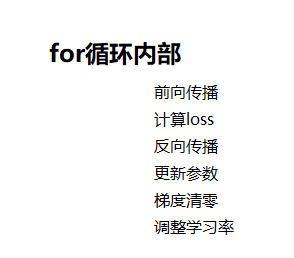